In [131]:
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format = 'retina'

## Q3 $k$ Nearest Neighbor

In [132]:
# 1) Load data.

X_and_Y = np.load('./ionosphere.npy')       # Load data from file.
print(X_and_Y.shape)

np.random.shuffle(X_and_Y)   # Shuffle the data.
X = X_and_Y[:,:-1]           # First column to second last column: Features (numerical values) 
Y = X_and_Y[:,-1]            # Last column: Labels (0 or 1)
print(X.shape, Y.shape)      # Check the shapes.

(351, 35)
(351, 34) (351,)


In [133]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (First 80% of all data points)
#    (b) Test set                       (Last 20% of all data points)
X_train_val = X[:int(round(0.8*len(X_and_Y))),:] # Get features from train + val set.
X_test      = X[int(round(0.8*len(X_and_Y))):,:] # Get features from test set.     
Y_train_val = Y[:int(round(0.8*len(X_and_Y)))] # Get labels from train + val set.
Y_test      = Y[int(round(0.8*len(X_and_Y))):] # Get labels from test set.  
print(X_train_val.shape,X_test.shape,Y_train_val.shape,Y_test.shape)

(281, 34) (70, 34) (281,) (70,)


In [134]:
# 3) Implement the k-NN.
class simple_KNeighborsClassifier(object):
    def __init__(self, k):
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        self.k = k
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, X_pred):
        """
        k-NN prediction function.
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), ).
        """
        Y_pred = []
        
        for x in X_pred:
            difference = self.X_train.reshape((len(self.X_train),-1)) - x.reshape((1,-1))
            distance = np.array(np.sum(np.abs(difference)**2,axis=-1)**(1./2)).reshape(-1,1)
            distance_with_label = np.hstack((distance,self.Y_train.reshape(-1,1)))
            distance_with_label = distance_with_label[np.argsort(distance_with_label[:,0])]
            k_labels = distance_with_label[:self.k,-1]
            label_0 = 0
            label_1 = 0
            for lab in k_labels:
                if lab == 0:
                    label_0 = label_0 + 1
                else:
                    label_1 = label_1 + 1
            if label_0 > label_1:
                Y_pred.append(0)
            else:
                Y_pred.append(1)
        return np.array(Y_pred)

In [135]:
# 4) Implement the cross-validation.

def simple_cross_validation(X_train_val, Y_train_val, k, fold):
    """
    A simple cross-validation function for k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k:           Parameter k for k-NN.
    fold:        The number of folds to do the cross-validation.
    
    Return the average accuracy on validation set.
    """ 
    val_acc_list = []
    train_acc_list = []
    for i in range(fold):
        
        length_each_fold = int(len(X_train_val)/fold)
        X_t = X_train_val[i*length_each_fold:i*length_each_fold + length_each_fold, :]
        Y_t = Y_train_val[i*length_each_fold:i*length_each_fold + length_each_fold,]
        Y_t = Y_t.reshape(-1,1)
        X_rest = np.delete(X_train_val, np.s_[i*length_each_fold:i*length_each_fold + length_each_fold], axis=0)
        Y_rest = np.delete(Y_train_val, np.s_[i*length_each_fold:i*length_each_fold + length_each_fold], axis=0)
        
        # Actually you can use the built-in function from sklearn
        # to validate if your implementation is correct or not:
        #    from sklearn.neighbors import KNeighborsClassifier
        classifier = simple_KNeighborsClassifier(k=k)
        classifier.fit(X_rest, Y_rest)
        
        p = classifier.predict(X_rest)
        correct = 0.0
        for z in range(p.size):
            if(p[z] == Y_rest[z]):
                correct = correct + 1
        train_accuracy = correct/p.size
                
        p = classifier.predict(X_t)
        correct = 0.0
        for z in range(p.size):
            if(p[z] == Y_t[z]):
                correct = correct + 1
        test_accuracy = correct/p.size
                
        train_acc_list.append(train_accuracy)
        val_acc_list.append(test_accuracy)  
        
    return sum(val_acc_list) / len(val_acc_list), \
           sum(train_acc_list) / len(train_acc_list)

In [136]:
# 5) Implement the grid search function.

def simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, fold):
    """
    A simple grid search function for k with cross-validation in k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k_list:      The list of k values to try.
    fold:        The number of folds to do the cross-validation.
    
    Return the val and train accuracy matrix of cross-validation. 
    All combinations of k are included in the array. 
    Shape: (len(k_list), )
    """
    val_acc_array = np.zeros(len(k_list))
    train_acc_array = np.zeros(len(k_list))
    for k in range(len(k_list)):
            val_acc, train_acc = simple_cross_validation(X_train_val, Y_train_val, k_list[k], fold)
            val_acc_array[k] = val_acc
            train_acc_array[k] = train_acc
    return val_acc_array, train_acc_array

In [137]:
# 6) Perform grid search.

k_list = [1,2,3,4,5,6]
val_acc_array, train_acc_array = \
    simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, 3)

In [138]:
# 7) Draw heatmaps for result of grid search and find 
#    best k on validation set.

def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$k$')
    plt.title(acc_desc + ' w.r.t $k$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#
# You can use the draw_heatmap_knn() to draw a heatmap to visualize 
# the accuracy w.r.t. k. Some demo code is given below as hint:
#
# demo_acc        = np.array([[0.8],
#                             [0.7]])
# demo_k_list     = [1, 2]
# draw_heatmap_linear(demo_acc, 'demo accuracy', demo_k_list)
#

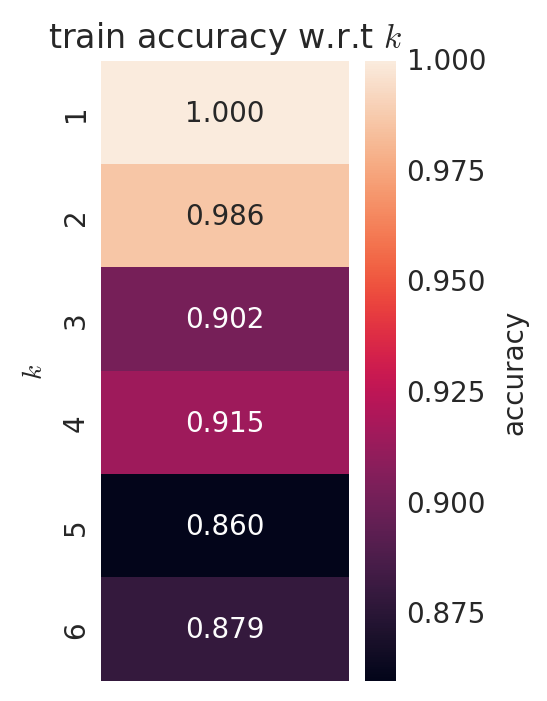

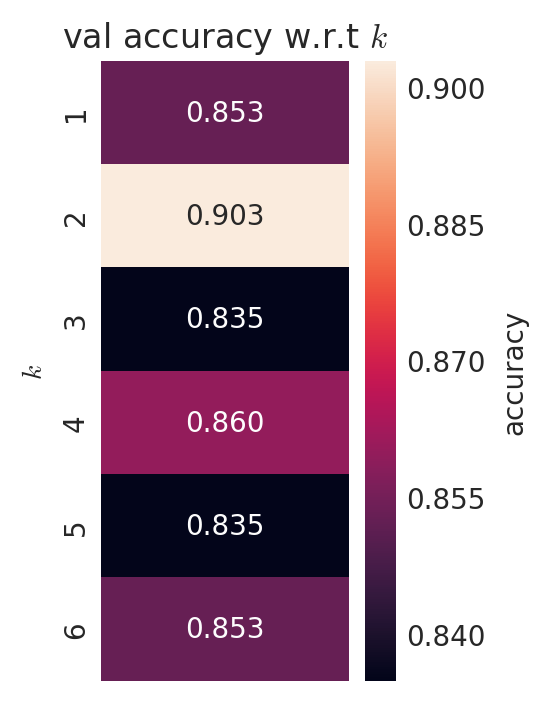

In [139]:
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', k_list)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', k_list)

In [140]:
# 8) Use the best k to calculate the test accuracy.
bestK_index = val_acc_array.argmax(axis=0)
classifier = simple_KNeighborsClassifier(k=k_list[bestK_index])
classifier.fit(X_train_val,Y_train_val)
Y_predict = classifier.predict(X_test)

correct = 0.0
for i in range(len(Y_test)):
    if Y_predict[i] == Y_test[i]:
        correct = correct + 1
print(correct/len(Y_test))

0.9142857142857143
